In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [83]:
train_data = pd.read_csv('eda_simple_classification/network_data_mod.csv')
test_data = pd.read_csv('eda_simple_classification/network_data_mod_test.csv')

train_labels = train_data["class"]
test_labels  = test_data["class"]

del train_data["class"]
del test_data["class"]

In [84]:
train_data.shape

(125973, 123)

In [85]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


'min_val = tf.reduce_min(train_data)\nmax_val = tf.reduce_max(train_data)\n\ntrain_data = (train_data - min_val) / (max_val - min_val)\ntest_data = (test_data - min_val) / (max_val - min_val)\n\ntrain_data = tf.cast(train_data, tf.float32)\ntest_data = tf.cast(test_data, tf.float32)'

In [86]:
train_labels = ndm_label.astype(bool)
test_labels = ndm_label_test.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [87]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(123, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [88]:
autoencoder.compile(optimizer='adam', loss='mae')

In [89]:
history = autoencoder.fit(train_data, train_data, 
          epochs=20, 
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
3937/3937 [==============================] - 8s 2ms/step - loss: 1049.0520 - val_loss: 198.2856
Epoch 2/20
3937/3937 [==============================] - 6s 2ms/step - loss: 1049.0385 - val_loss: 198.2801
Epoch 3/20
3937/3937 [==============================] - 6s 2ms/step - loss: 1049.0365 - val_loss: 198.2798
Epoch 4/20
3937/3937 [==============================] - 6s 2ms/step - loss: 1049.0228 - val_loss: 198.2688
Epoch 5/20
3937/3937 [==============================] - 7s 2ms/step - loss: 1049.0193 - val_loss: 198.2700
Epoch 6/20
3937/3937 [==============================] - 7s 2ms/step - loss: 1049.0250 - val_loss: 198.2734
Epoch 7/20
3937/3937 [==============================] - 7s 2ms/step - loss: 1049.0228 - val_loss: 198.2731
Epoch 8/20
  64/3937 [..............................] - ETA: 6s - loss: 603.8546

KeyboardInterrupt: 

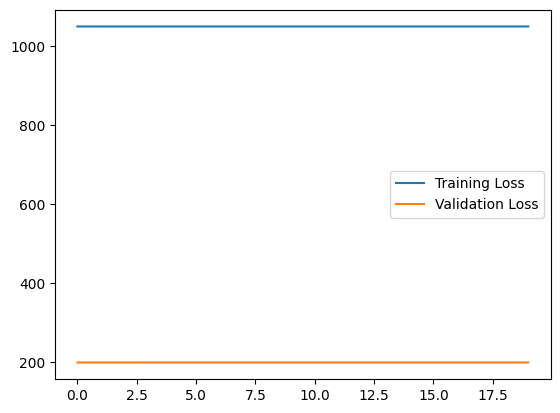

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

NameError: name 'predict' is not defined